<a href="https://colab.research.google.com/github/sur-sakthy/computer-vision/blob/main/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment #2

In [1]:
!nvidia-smi

Sat Mar 18 10:02:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!cp '/content/drive/MyDrive/EE544 Computer Vision/imagewoof2-320.tgz' ./

In [3]:
# remove %%capture command to show output from unzipping
%%capture
!tar zxvf /content/imagewoof2-320.tgz

## Imports

In [4]:
import os
import cv2
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, AUC, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

## Constants

In [5]:
PATH_TO_TRAIN_DATA = '/content/imagewoof2-320/train'
PATH_TO_VAL_DATA = '/content/imagewoof2-320/val'

IMG_WIDTH=224
IMG_HEIGHT=224

NUM_CLASSES=3

In [6]:
all_classes = os.listdir(PATH_TO_TRAIN_DATA)
all_classes

['n02093754',
 'n02096294',
 'n02087394',
 'n02099601',
 'n02088364',
 'n02115641',
 'n02086240',
 'n02105641',
 'n02111889',
 'n02089973']

In [7]:
all_classes = os.listdir(PATH_TO_VAL_DATA)
all_classes

['n02093754',
 'n02096294',
 'n02087394',
 'n02099601',
 'n02088364',
 'n02115641',
 'n02086240',
 'n02105641',
 'n02111889',
 'n02089973']

## Load dataset

In [8]:
data = []
labels = []

In [9]:
def load_dataset(img_folder): 
    for dir in os.listdir(img_folder):
      if dir == 'n02105641' or dir == 'n02087394' or dir == 'n02096294':
        for file in os.listdir(os.path.join(img_folder, dir)):
       
            image_path = os.path.join(img_folder, dir, file)
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
            image = np.array(image)

            data.append(image)
            labels.append(dir)

In [10]:
load_dataset(PATH_TO_TRAIN_DATA)
load_dataset(PATH_TO_VAL_DATA)

In [11]:
np.unique(labels)

array(['n02087394', 'n02096294', 'n02105641'], dtype='<U9')

In [12]:
data[0]

array([[[153, 108,  87],
        [108, 145, 189],
        [ 94, 146, 203],
        ...,
        [105, 174, 215],
        [ 98, 180, 217],
        [ 89, 180, 211]],

       [[162, 119, 100],
        [ 97, 129, 168],
        [101, 151, 204],
        ...,
        [135, 203, 242],
        [123, 197, 234],
        [121, 197, 233]],

       [[163, 122, 104],
        [ 91, 119, 156],
        [109, 155, 205],
        ...,
        [127, 192, 230],
        [129, 197, 234],
        [120, 185, 223]],

       ...,

       [[ 45,  80, 110],
        [ 47,  78, 107],
        [ 67,  84, 110],
        ...,
        [ 93,  93,  69],
        [ 91,  88,  71],
        [ 95,  90,  86]],

       [[ 48,  89, 117],
        [ 50,  85, 113],
        [ 60,  82, 106],
        ...,
        [ 92,  91,  60],
        [ 95,  89,  65],
        [ 95,  86,  77]],

       [[ 45,  92, 118],
        [ 42,  84, 108],
        [ 64,  94, 118],
        ...,
        [ 98,  99,  59],
        [ 92,  86,  54],
        [ 97,  85,  71]]

In [13]:
np.min(data), np.max(data)

(0, 255)

## Split dataset

In [14]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.33, random_state=42)

## Class distribution

In [15]:
df_train = pd.DataFrame(y_train, columns=['label'])
df_train.head()

,label
0,n02105641
1,n02087394
2,n02105641
3,n02087394
4,n02087394


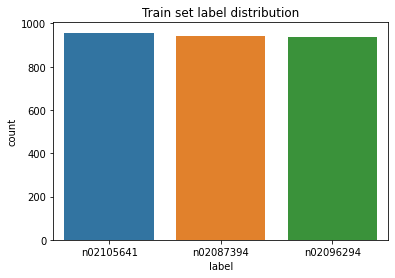

In [16]:
sns.countplot(data=df_train, x='label')
plt.title('Train set label distribution') 
plt.show()

In [17]:
df_test = pd.DataFrame(y_test, columns=['label'])
df_test.head()

,label
0,n02096294
1,n02096294
2,n02105641
3,n02096294
4,n02105641


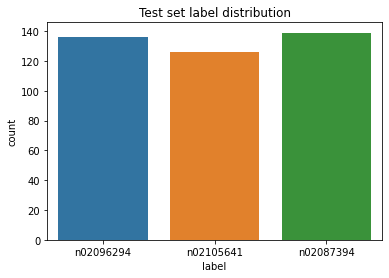

In [18]:
sns.countplot(data=df_test, x='label')
plt.title('Test set label distribution') 
plt.show()

In [19]:
df_val = pd.DataFrame(y_val, columns=['label'])
df_val.head()

,label
0,n02087394
1,n02105641
2,n02096294
3,n02096294
4,n02087394


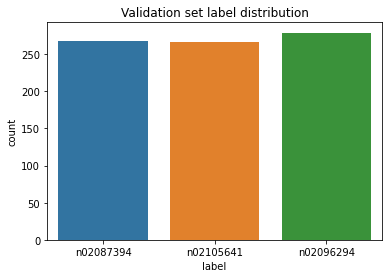

In [20]:
sns.countplot(data=df_val, x='label')
plt.title('Validation set label distribution') 
plt.show()

## Encoding

In [21]:
def one_hot_encode(y, num_classes):
  le = LabelEncoder()
  return to_categorical(le.fit_transform(y), num_classes)

In [22]:
y_train[0]

'n02105641'

In [23]:
y_train = one_hot_encode(y_train, NUM_CLASSES)

In [24]:
y_train[0]

array([0., 0., 1.], dtype=float32)

In [25]:
y_test[0]

'n02096294'

In [26]:
y_test = one_hot_encode(y_test, NUM_CLASSES)

In [27]:
y_test[0]

array([0., 1., 0.], dtype=float32)

In [28]:
np.array(y_train).shape

(2835, 3)

In [29]:
y_val[0]

'n02087394'

In [30]:
y_val = one_hot_encode(y_val, NUM_CLASSES)

In [31]:
y_val

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

## Create train, validation and test sets

In [32]:
train_datagen = ImageDataGenerator( 
    rescale=1./255,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [33]:
train_ds = train_datagen.flow(
  np.array(X_train), y_train,
  shuffle=True,
  batch_size=128
)

val_ds = val_datagen.flow(
  np.array(X_val), y_val,
  shuffle=True,
  batch_size=128
)

test_ds = test_datagen.flow(
  np.array(X_test), y_test,
  shuffle=False,
  batch_size=128
)

In [34]:
print('Shape of training samples: ', train_ds.x.shape)
print('Shape of validation samples: ', val_ds.x.shape)
print('Shape of test samples: ', test_ds.x.shape)

Shape of training samples:  (2835, 224, 224, 3)
Shape of validation samples:  (814, 224, 224, 3)
Shape of test samples:  (401, 224, 224, 3)


## Build model

In [35]:
def build_model():
  base_model = ResNet50(include_top=False, weights='imagenet')

  for layer in base_model.layers[:-33]: 
    layer.trainable = False

  # add a global spatial average pooling layer
  x = GlobalAveragePooling2D()(base_model.output)

  # add fully-connected
  x = Dense(512, activation='relu', name='fc-1')(x) 
  x = Dense(256, activation='relu', name='fc-2')(x)

  # a softmax layer for 3 classes
  out = Dense(3, activation='softmax', name='output_layer')(x)

  model = Model(base_model.input, out)

  model.compile(
      optimizer=Adam(),
      loss='categorical_crossentropy',
      metrics=[
          CategoricalAccuracy(),
          Precision(), 
          Recall(),
          AUC()
        ]
  )

  return model

In [36]:
custom_resnet_model = build_model()

94765736/94765736 [==============================] - 1s 0us/step


In [37]:
custom_resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

In [38]:
# remove command to show output 
%%capture 
for i in range(len(custom_resnet_model.layers)): 
  print(str(i) + ': ' + str(custom_resnet_model.layers[i].trainable))

## Train model

### Initialise callbacks

In [39]:
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=20)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/EE544 Computer Vision/task-2-weights.hdf5', verbose=1, save_best_only=True, monitor='val_categorical_accuracy')

### Fit the model

In [40]:
resnet_history = custom_resnet_model.fit(
    train_ds,
    epochs=30,
    verbose=1,
    validation_data=val_ds,
    callbacks=[checkpoint]
)

Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 1.3106 - categorical_accuracy: 0.3683 - precision: 0.4025 - recall: 0.1019 - auc: 0.5461
Epoch 1: val_categorical_accuracy improved from -inf to 0.33170, saving model to /content/drive/MyDrive/EE544 Computer Vision/task-2-weights.hdf5
23/23 [==============================] - 44s 802ms/step - loss: 1.3106 - categorical_accuracy: 0.3683 - precision: 0.4025 - recall: 0.1019 - auc: 0.5461 - val_loss: 1.4609 - val_categorical_accuracy: 0.3317 - val_precision: 0.3337 - val_recall: 0.3292 - val_auc: 0.5498
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 0.9736 - categorical_accuracy: 0.5210 - precision: 0.6452 - recall: 0.2790 - auc: 0.7128
Epoch 2: val_categorical_accuracy did not improve from 0.33170
23/23 [==============================] - 14s 594ms/step - loss: 0.9736 - categorical_accuracy: 0.5210 - precision: 0.6452 - recall: 0.2790 - auc: 0.7128 - val_loss: 13.8669 - val_categorical_accuracy: 0.3280

## Plot the results

In [41]:
def plot(train, validation, ylabel, title):
  plt.plot(train, color='red', label='train') 
  plt.plot(validation, color='blue', label='validation') 
  plt.title(title) 
  plt.ylabel(ylabel)
  plt.xlabel('Epoch')
  plt.legend() 
  plt.grid(linestyle='-', linewidth=0.5)

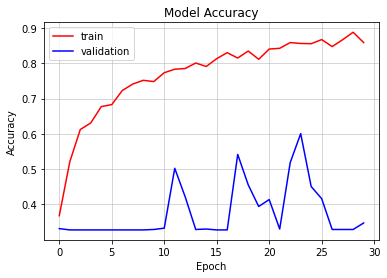

In [42]:
plot(resnet_history.history['categorical_accuracy'], resnet_history.history['val_categorical_accuracy'], 'Accuracy', 'Model Accuracy')

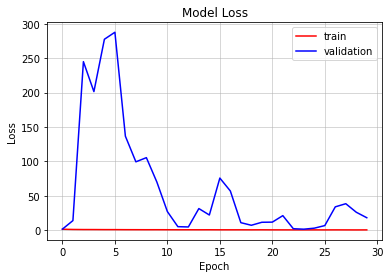

In [43]:
plot(resnet_history.history['loss'], resnet_history.history['val_loss'], 'Loss', 'Model Loss')

## Evaluate model

In [44]:
def evaluate_and_predict(model): 
  # evaluate on test dataset
  eval_results = model.evaluate(test_ds, batch_size=30)

  # print evaluation results
  print('Test loss:', eval_results[0])
  print('Test categorical_accuracy:', eval_results[1])
  print('Test precision:', eval_results[2])
  print('Test recall:', eval_results[3])
  print('Test auc:', eval_results[4])

  # predict
  return model.predict(test_ds)

In [45]:
pred = evaluate_and_predict(custom_resnet_model)

4/4 [==============================] - 2s 469ms/step - loss: 18.6522 - categorical_accuracy: 0.3441 - precision: 0.3441 - recall: 0.3441 - auc: 0.5051
Test loss: 18.652233123779297
Test categorical_accuracy: 0.3441396653652191
Test precision: 0.3441396653652191
Test recall: 0.3441396653652191
Test auc: 0.50505131483078
4/4 [==============================] - 2s 410ms/step


In [46]:
pred

array([[3.8026270e-17, 6.4528394e-03, 9.9354714e-01],
       [9.9860274e-20, 2.8885111e-08, 1.0000000e+00],
       [6.7673399e-25, 2.1788549e-18, 1.0000000e+00],
       ...,
       [4.1642190e-15, 8.8860124e-04, 9.9911135e-01],
       [6.0910139e-18, 3.6420165e-08, 1.0000000e+00],
       [7.6423643e-16, 1.4451965e-05, 9.9998558e-01]], dtype=float32)

In [47]:
def draw_confusion_matrix(true, pred):
  cm = confusion_matrix(true.argmax(axis=1), pred.argmax(axis=1))
  sns.heatmap(cm, annot=True, annot_kws={"size": 12}, fmt='g', cbar=False, cmap="viridis")
  plt.show()

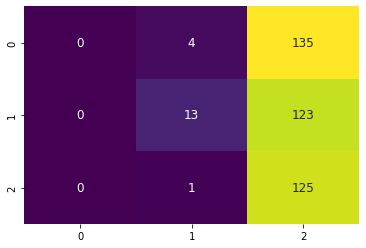

In [48]:
draw_confusion_matrix(y_test, pred)

In [49]:
print(classification_report(y_test.argmax(axis=1), pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       139
           1       0.72      0.10      0.17       136
           2       0.33      0.99      0.49       126

    accuracy                           0.34       401
   macro avg       0.35      0.36      0.22       401
weighted avg       0.35      0.34      0.21       401



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
